In [1]:
import cv2
from imgaug import augmenters as iaa
import numpy as np
import imageio
from matplotlib import pyplot as plt
import tqdm
import glob
import pandas as pd
import json
import os

## Visualizing the augmented method 
Action required!
1. Define your own directory
2. Pick a augmentation method (comment out the one you dont want)

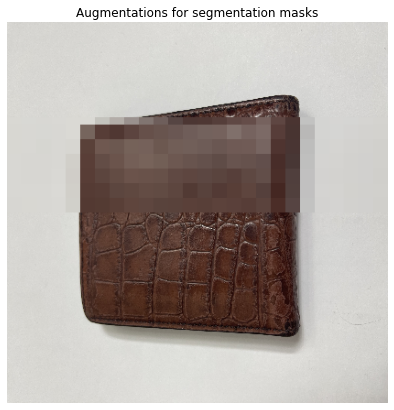

In [25]:
# use imageio library to read the image (alternatively you can use OpenCV cv2.imread() function)
img = imageio.imread('/media/eric/BulkyStorage/datasets/cv2/2021_project/individual_dataset/individual_item/IMG_0698.JPG')
img = cv2.resize(img, (416, 416))
# initialize the augmenter
rotate = iaa.CoarseDropout(p = (0.2), size_percent=(0.01, 0.01))#, per_channel=0.2)
random_blur = iaa.BlendAlphaRegularGrid(nb_rows=(1, 4), nb_cols=(1, 4), foreground=iaa.AveragePooling(16), alpha=[0.0, 0.0, 1.0])
jigsaw = iaa.Jigsaw(nb_rows=4, nb_cols=4, max_steps=(1, 4))    

# choose which kind of augmentation method
# image_aug = rotate.augment_images([img])[0]
image_aug = random_blur.augment_images([img])[0]
# image_aug = jigsaw.augment_images([img])[0]

fig, ax = plt.subplots(figsize=(10, 7))
ax.axis('off')
plt.title('Augmentations for segmentation masks')
ax.imshow(image_aug)

# Data Augmentation 
Action required!
1. Define your own directory
2. Pick a augmentation method (comment out the one you dont want)

Copy the train folder (directory) for later augmentation as train_copy

In [27]:
!cp -R ./2021_project/Occluded_final/train ./2021_project/Occluded_final/train_copy

In [28]:
json_root = "/media/eric/BulkyStorage/datasets/cv2/2021_project/Occluded_final/train_copy/_annotations.coco_copy.json"
# Reading the json as a dict
with open(json_root) as json_data:
    data = json.load(json_data)

annotations_df = pd.DataFrame(data['annotations'])
images_df = pd.DataFrame(data['images'])
data.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [29]:
# id_anno = int(images_df.loc[(images_df['file_name'] == base+'.jpg')]['id'])
# annotations_df.loc[(annotations_df['image_id'] == id_anno)]['bbox']
# const = 100000


# # # store the filename and the image_id
# # images_s      = images_df.loc[(images['file_name'] == base+'.jpg')]
# # images_s['file_name'] = 'aaa'+images_s['file_name']
# # images_s['id'] = images_s['id'] + const
# # images_augment_df = images_augment_df.append(images_s)

# # annotations_s = annotations_df.loc[(images['file_name'] == base+'.jpg')]
# # annotations_s['image_id'] = images_s['id']
# # annotations_aug_df = annotations_aug_df.append(annotations_s)

# # annotations_aug_df

In [30]:
const = 100000
images_augment_df = pd.DataFrame()
annotations_aug_df = pd.DataFrame()

train_img_root = '/media/eric/BulkyStorage/datasets/cv2/2021_project/Occluded_final/train_copy'
save_to        = '/media/eric/BulkyStorage/datasets/cv2/2021_project/Occluded_final/train_copy/'

# list the filenames.jpg 
img_list = (glob.glob(train_img_root + '/*.jpg'))
N = 1
for name in tqdm.tqdm(img_list):
    
    #get filename
    base = os.path.basename(name)
    base = os.path.splitext(base)[0]
    
    #for json file find encoded ID
    id_anno = int(images_df.loc[(images_df['file_name'] == base+'.jpg')]['id'])
    
    # find gound truth
    bbox = annotations_df.loc[(annotations_df['image_id'] == id_anno)]['bbox']
    bbox = list(bbox)[0]
    img = imageio.imread(train_img_root+'/'+base+'.jpg')
    
    # generate N augmented-images per image
    for i in range(N):
        
        # store the filename
        images_s      = images_df.loc[(images_df['file_name'] == base+'.jpg')]
        images_s['file_name'] = base + str(i) + '.jpg'
        images_s['id'] = images_s['id'] + const + i
        images_augment_df = images_augment_df.append(images_s)

        # store the image_id
        annotations_s = annotations_df.loc[(images_df['file_name'] == base+'.jpg')]
        annotations_s['image_id'] = images_s['id']
        annotations_s['id'] = images_s['id']
        annotations_aug_df = annotations_aug_df.append(annotations_s)

        # data augmentation choice
        rotate = iaa.CoarseDropout(p = (0.2), size_percent=(0.01, 0.01))#, per_channel=0.2)
        random_blur = iaa.BlendAlphaRegularGrid(nb_rows=(1, 4), nb_cols=(1, 4), foreground=iaa.AveragePooling(16), alpha=[0.0, 0.0, 1.0])
        jigsaw = iaa.Jigsaw(nb_rows=4, nb_cols=4, max_steps=(1, 4))
        
        # choose which kind of augmentation method
        # image_aug = rotate.augment_images([img])[0]
        image_aug = random_blur.augment_images([img])[0]
        # image_aug = jigsaw.augment_images([img])[0]
        
        # Resize and save the augmented images
        image_aug = cv2.resize(image_aug, (416, 416))
        image_aug = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
        cv2.imwrite(save_to+'/'+ base + str(i)+ '.jpg', image_aug)

        #draw bbox and gt
        (x1, y1) = (int(bbox[0]), int(bbox[1]))
        (x2, y2) = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv2.rectangle(image_aug, (x1, y1), (x2, y2), [0, 0, 0], 2)
        
        # for visualization
        # plt.imshow(image_aug)
        # plt.show()

    # cv2.imshow('window',  image_aug)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

100%|██████████| 204/204 [00:09<00:00, 22.59it/s]


In [31]:
# Turn augmentation into dictionary to Json file
annotations_aug = annotations_aug_df.to_dict('records')
images_augment = images_augment_df.to_dict('records')

#updating Json file after augmentation
for i in range(len(images_augment)):
    data['images'].append(images_augment[i])
    data['annotations'].append(annotations_aug[i])

a_file = open(json_root, "w")
json.dump(data, a_file)
a_file.close()

In [32]:
# with open(json_root) as json_data:
#     data = json.load(json_data)
# temp = pd.DataFrame(data['images'])
# temp['id'].value_counts()

Compress the Occluded_final folder(directory) as a zip file, and now ready to upload this to Colab for training!

In [33]:
!zip -r ./2021_project/Occluded_final.zip ./2021_project/Occluded_final/

f5fef35c106513b3ed97be4c.jpg (deflated 1%)
updating: 2021_project/Occluded_final/test/File_146_jpeg.rf.0676075b5795e0c9376926a2ef3f2cfb.jpg (deflated 1%)
updating: 2021_project/Occluded_final/test/File_090_jpeg.rf.f450a32cf5bedaab3ef008af47265c95.jpg (deflated 1%)
updating: 2021_project/Occluded_final/test/File_105_jpeg.rf.a22f1ff19d13d988fa42c2a13a3f0b66.jpg (deflated 1%)
updating: 2021_project/Occluded_final/test/File_037_jpeg.rf.595f59875e9b332d1f4be4701e1bbcf7.jpg (deflated 1%)
updating: 2021_project/Occluded_final/test/File_030_jpeg.rf.2dca7035e74b03293dc1093896070fec.jpg (deflated 1%)
updating: 2021_project/Occluded_final/test/File_125_jpeg.rf.998de8cec2244dc4a2d86bb8e801aad3.jpg (deflated 1%)
updating: 2021_project/Occluded_final/test/File_007_jpeg.rf.5a328ed2e72f74c605f3c18a3e61af2a.jpg (deflated 0%)
updating: 2021_project/Occluded_final/test/File_012_jpeg.rf.9f7ccf4c8feb43c1a97d46c9b8d7fe92.jpg (deflated 1%)
updating: 2021_project/Occluded_final/test/File_024_jpeg.rf.ca99d610a